# Tutorial 1: Basic Analysis Workflow

**ScpTensor v0.1.0-beta**

This tutorial demonstrates a complete single-cell proteomics (SCP) analysis pipeline using ScpTensor. You will learn:

1. **Data Generation** - Create synthetic SCP data with realistic missing patterns
2. **Quality Control** - Basic QC metrics and visualization
3. **Normalization** - Log transformation for variance stabilization
4. **Imputation** - KNN-based missing value filling
5. **Dimensionality Reduction** - PCA for visualization
6. **Clustering** - K-means clustering
7. **Visualization** - Result visualization with SciencePlots style

---

## 1. Setup and Imports

First, let's import the required libraries and configure the plotting style.

In [1]:
# Core imports
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import scienceplots

# ScpTensor imports
from scptensor.core import ScpContainer, Assay, ScpMatrix
from scptensor.normalization import log_normalize
from scptensor.impute import knn
from scptensor.cluster import run_kmeans
from scptensor.dim_reduction import pca
from scptensor.viz.recipes import qc_completeness, embedding

# Configure plotting with SciencePlots style
plt.style.use(["science", "no-latex"])
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

print("Imports successful! ScpTensor is ready to use.")

/home/shenshang/projects/ScpTensor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports successful! ScpTensor is ready to use.


## 2. Generate Synthetic SCP Data

In a real analysis, you would load your own data. For this tutorial, we'll generate synthetic data that mimics real single-cell proteomics data:

- **200 samples** (cells) across **2 biological groups**
- **1000 features** (proteins/peptides)
- **Missing values** introduced with realistic patterns:
  - **LOD (Limit of Detection)**: 20% - values below detection threshold
  - **MBR (Missing Between Runs)**: 30% - random missingness

The `M` mask matrix tracks the provenance of each value:
- `0`: VALID (detected value)
- `1`: MBR (missing between runs)
- `2`: LOD (below detection limit)

In [2]:
def generate_synthetic_data(n_samples=200, n_features=1000):
    """
    Generate synthetic single-cell proteomics data with realistic missing patterns.
    
    Returns
    -------
    ScpContainer
        Container with synthetic SCP data.
    """
    np.random.seed(42)
    
    # Create sample metadata
    groups = np.array(['GroupA'] * (n_samples // 2) + ['GroupB'] * (n_samples - n_samples // 2))
    batches = np.random.choice(['Batch1', 'Batch2'], size=n_samples)
    
    obs = pl.DataFrame({
        'sample_id': [f'S{i+1:03d}' for i in range(n_samples)],
        'group': groups,
        'batch': batches
    })
    
    # Generate expression data with biological signal
    X_true = np.random.lognormal(mean=2, sigma=0.5, size=(n_samples, n_features))
    # Add group effect (first 100 proteins are higher in GroupB)
    X_true[groups == 'GroupB', :100] *= 2.0
    # Add batch effect (Batch2 has slightly higher values)
    X_true[batches == 'Batch2', :] *= 1.3
    
    # Introduce missing values
    X_observed = X_true.copy()
    M = np.zeros((n_samples, n_features), dtype=int)
    
    # Systematic missing (LOD) - 20% below threshold
    threshold = np.percentile(X_true, 20)
    lod_mask = X_true < threshold
    X_observed[lod_mask] = 0
    M[lod_mask] = 2  # LOD mask code
    
    # Random missing (MBR) - 30% of remaining values
    n_random_missing = int(n_samples * n_features * 0.3)
    valid_indices = np.argwhere(M == 0)
    random_indices = valid_indices[np.random.choice(len(valid_indices), size=n_random_missing, replace=False)]
    X_observed[random_indices[:, 0], random_indices[:, 1]] = 0
    M[random_indices[:, 0], random_indices[:, 1]] = 1  # MBR mask code
    
    # Create feature metadata
    var = pl.DataFrame({
        'protein_id': [f'P{i+1:04d}' for i in range(n_features)],
        '_index': [f'P{i+1:04d}' for i in range(n_features)]
    })
    
    # Create ScpContainer
    matrix = ScpMatrix(X=X_observed, M=M)
    assay = Assay(var=var, layers={'raw': matrix}, feature_id_col='protein_id')
    
    container = ScpContainer(
        assays={'protein': assay},
        obs=obs.with_columns(pl.Series(name="_index", values=obs["sample_id"].to_list())),
        sample_id_col='sample_id'
    )
    
    return container

# Generate the data
container = generate_synthetic_data(n_samples=200, n_features=1000)

# Display data summary
print(f"Generated data:")
print(f"  - Samples: {container.n_samples}")
print(f"  - Features: {container.n_features}")
print(f"  - Missing rate: {np.mean(container.assays['protein'].layers['raw'].M != 0):.1%}")
print(f"\nSample metadata (first 5 rows):")
print(container.obs.head())

Generated data:
  - Samples: 200
  - Features: 1000
  - Missing rate: 50.0%

Sample metadata (first 5 rows):
shape: (5, 4)
┌───────────┬────────┬────────┬────────┐
│ sample_id ┆ group  ┆ batch  ┆ _index │
│ ---       ┆ ---    ┆ ---    ┆ ---    │
│ str       ┆ str    ┆ str    ┆ str    │
╞═══════════╪════════╪════════╪════════╡
│ S001      ┆ GroupA ┆ Batch1 ┆ S001   │
│ S002      ┆ GroupA ┆ Batch2 ┆ S002   │
│ S003      ┆ GroupA ┆ Batch1 ┆ S003   │
│ S004      ┆ GroupA ┆ Batch1 ┆ S004   │
│ S005      ┆ GroupA ┆ Batch1 ┆ S005   │
└───────────┴────────┴────────┴────────┘


## 3. Quality Control

Quality control is essential before any analysis. Let's visualize the data completeness by batch to check for any systematic biases.

The `qc_completeness` function shows the number of measured (non-missing) features per sample, grouped by metadata.

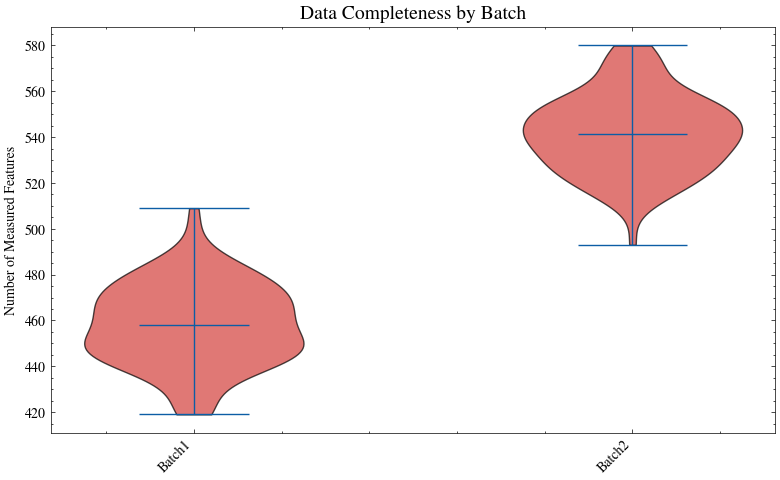

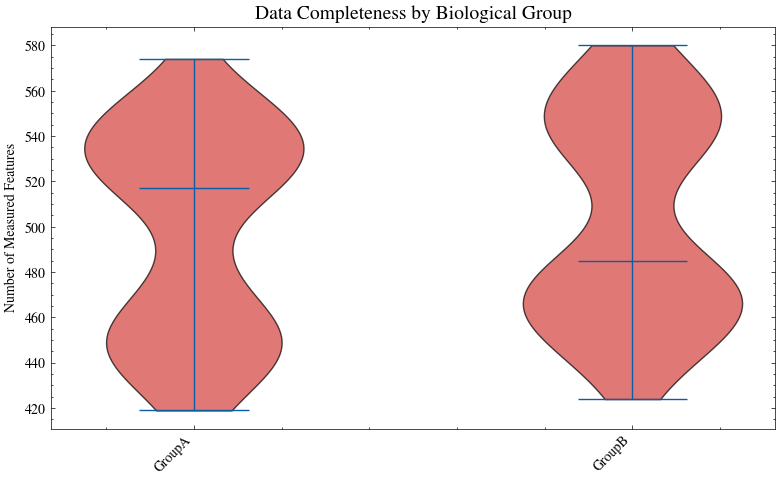

In [3]:
# Visualize data completeness by batch
fig, ax = plt.subplots(figsize=(8, 5))
qc_completeness(container, group_by='batch', ax=ax)
plt.title("Data Completeness by Batch", fontsize=14)
plt.tight_layout()
plt.show()

# Also check by group
fig, ax = plt.subplots(figsize=(8, 5))
qc_completeness(container, group_by='group', ax=ax)
plt.title("Data Completeness by Biological Group", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Normalization (Log Transform)

SCP data typically has a right-skewed distribution. Log transformation stabilizes variance and makes the data more normally distributed.

**Formula:** `log(X + offset)` where:
- `X` is the input data
- `base` is the logarithm base (default: 2)
- `offset` handles zeros (default: 1.0)

This creates a new layer called `'log'` without modifying the original data.

Log normalization complete!

Available layers in 'protein' assay: ['raw', 'log']


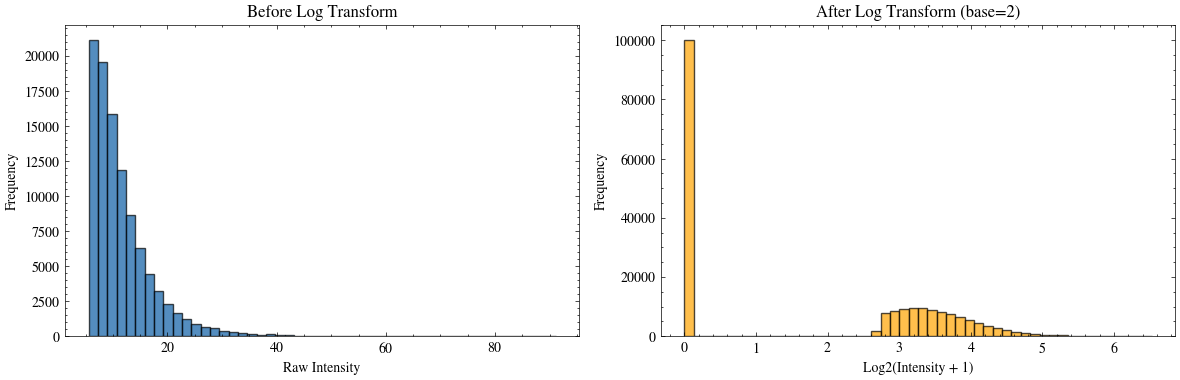

In [4]:
# Apply log normalization
container = log_normalize(
    container,
    assay_name='protein',
    base_layer='raw',
    new_layer_name='log',
    base=2.0,
    offset=1.0
)

print("Log normalization complete!")
print(f"\nAvailable layers in 'protein' assay: {list(container.assays['protein'].layers.keys())}")

# Compare distributions before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before log
X_raw = container.assays['protein'].layers['raw'].X.flatten()
X_raw_valid = X_raw[X_raw > 0]  # Only non-zero values
axes[0].hist(X_raw_valid, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Before Log Transform', fontsize=12)
axes[0].set_xlabel('Raw Intensity')
axes[0].set_ylabel('Frequency')

# After log
X_log = container.assays['protein'].layers['log'].X.flatten()
axes[1].hist(X_log, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_title('After Log Transform (base=2)', fontsize=12)
axes[1].set_xlabel('Log2(Intensity + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Imputation (KNN)

Missing values are common in SCP data. K-Nearest Neighbors (KNN) imputation fills missing values based on similar samples.

**How it works:**
1. For each sample with missing values, find the k most similar samples
2. Fill missing values using the weighted average from neighbors

**Note:** Imputation is performed on the log-transformed data for better numerical stability.

In [5]:
# Apply KNN imputation
container = knn(
    container,
    assay_name='protein',
    base_layer='log',
    new_layer_name='imputed',
    k=5
)

print("KNN imputation complete!")
print(f"\nAvailable layers: {list(container.assays['protein'].layers.keys())}")

# Check missing rates before and after
missing_before = np.mean(container.assays['protein'].layers['log'].M != 0)
missing_after = np.mean(container.assays['protein'].layers['imputed'].M != 0)

print(f"\nMissing rate:")
print(f"  - Before imputation: {missing_before:.1%}")
print(f"  - After imputation:  {missing_after:.1%}")

# Verify imputed values are reasonable
X_imputed = container.assays['protein'].layers['imputed'].X
M_imputed = container.assays['protein'].layers['imputed'].M

# Count imputed values (mask code = 5)
n_imputed = np.sum(M_imputed == 5)
print(f"\nTotal values imputed: {n_imputed}")

No missing values found. Copying layer.
KNN imputation complete!

Available layers: ['raw', 'log', 'imputed']

Missing rate:
  - Before imputation: 50.0%
  - After imputation:  50.0%

Total values imputed: 0


## 6. Dimensionality Reduction (PCA)

Principal Component Analysis (PCA) reduces dimensionality while preserving variance. This enables visualization and noise reduction.

**Key parameters:**
- `n_components`: Number of principal components to compute
- `center`: Center the data before PCA (recommended)
- `scale`: Scale to unit variance (optional, for feature-weighted data)

PCA creates a new assay with:
- **scores**: Sample coordinates in PC space
- **loadings**: Feature contributions stored in original assay metadata

PCA complete!

Available assays: ['protein', 'pca']

Principal Components:
shape: (10, 3)
┌─────────┬────────────────────┬──────────────────────────┐
│ pc_name ┆ explained_variance ┆ explained_variance_ratio │
│ ---     ┆ ---                ┆ ---                      │
│ str     ┆ f64                ┆ f64                      │
╞═════════╪════════════════════╪══════════════════════════╡
│ PC1     ┆ 59.337709          ┆ 0.0182                   │
│ PC2     ┆ 40.061878          ┆ 0.012288                 │
│ PC3     ┆ 33.635158          ┆ 0.010316                 │
│ PC4     ┆ 32.77872           ┆ 0.010054                 │
│ PC5     ┆ 32.331977          ┆ 0.009917                 │
│ PC6     ┆ 31.880269          ┆ 0.009778                 │
│ PC7     ┆ 31.234653          ┆ 0.00958                  │
│ PC8     ┆ 30.763835          ┆ 0.009436                 │
│ PC9     ┆ 30.345458          ┆ 0.009307                 │
│ PC10    ┆ 29.945242          ┆ 0.009185                 │
└─────────

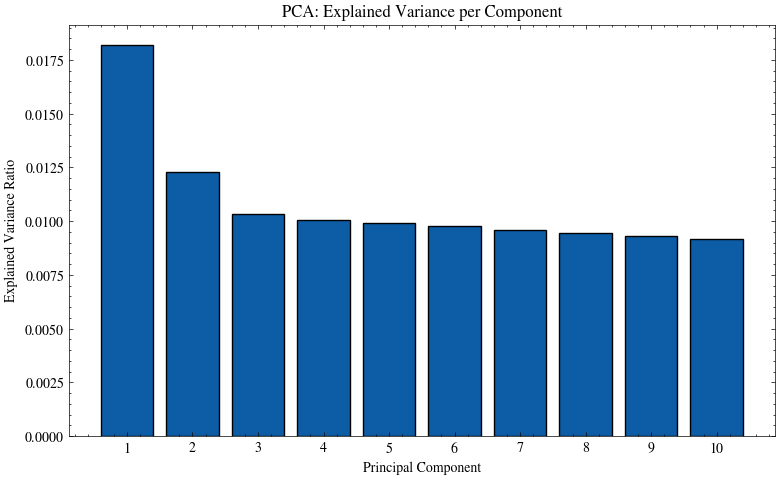

In [6]:
# Run PCA
container = pca(
    container,
    assay_name='protein',
    base_layer_name='imputed',
    new_assay_name='pca',
    n_components=10,
    center=True,
    scale=False
)

print("PCA complete!")
print(f"\nAvailable assays: {list(container.assays.keys())}")

# Check explained variance
pca_var = container.assays['pca'].var
print("\nPrincipal Components:")
print(pca_var)

# Plot explained variance
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(1, 11), pca_var['explained_variance_ratio'].to_numpy(), edgecolor='black')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA: Explained Variance per Component')
ax.set_xticks(range(1, 11))
plt.tight_layout()
plt.show()

## 7. Clustering (K-Means)

K-means clustering groups similar samples based on their PCA coordinates.

**Key parameters:**
- `n_clusters`: Number of clusters (k)
- `key_added`: Name for the cluster label column in obs

This creates:
1. A new assay with one-hot encoded cluster assignments
2. A cluster label column in the sample metadata (obs)

In [7]:
# Run K-means clustering
container = run_kmeans(
    container,
    assay_name='pca',
    base_layer='scores',
    n_clusters=2,
    key_added='kmeans_cluster',
    random_state=42
)

print("K-means clustering complete!")
print(f"\nAvailable assays: {list(container.assays.keys())}")

# Check cluster distribution
print("\nCluster distribution:")
print(container.obs['kmeans_cluster'].value_counts())

# Compare with true groups
print("\nTrue group distribution:")
print(container.obs['group'].value_counts())

K-means clustering complete!

Available assays: ['protein', 'pca', 'cluster_kmeans']

Cluster distribution:
shape: (2, 2)
┌────────────────┬───────┐
│ kmeans_cluster ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ 1              ┆ 116   │
│ 0              ┆ 84    │
└────────────────┴───────┘

True group distribution:
shape: (2, 2)
┌────────┬───────┐
│ group  ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ GroupB ┆ 100   │
│ GroupA ┆ 100   │
└────────┴───────┘


## 8. Visualization

Now let's visualize the results using PCA embeddings colored by:
1. **K-means clusters** - Discovered group structure
2. **True groups** - Biological groups (ground truth)
3. **Batch** - Technical variation

ValueError: Assay 'proteins' not found in container

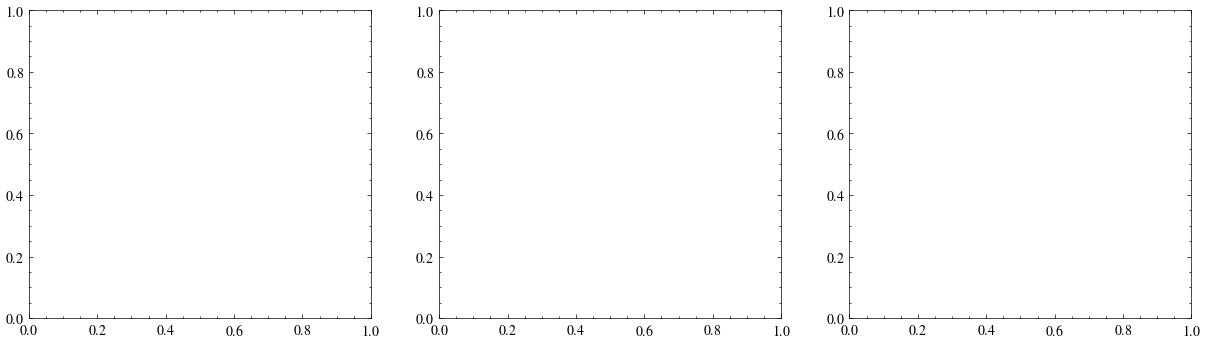

In [8]:
# Create a multi-panel visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: By cluster
plt.sca(axes[0])
embedding(container, basis='pca', color='kmeans_cluster')
plt.title("By K-means Cluster")

# Panel 2: By true group
plt.sca(axes[1])
embedding(container, basis='pca', color='group')
plt.title("By Biological Group")

# Panel 3: By batch
plt.sca(axes[2])
embedding(container, basis='pca', color='batch')
plt.title("By Batch")

plt.tight_layout()
plt.show()

# Calculate clustering accuracy (Adjusted Rand Index approximation)
from sklearn.metrics import adjusted_rand_score

# Convert string labels to numeric
cluster_labels = container.obs['kmeans_cluster'].to_numpy()
group_labels = container.obs['group'].to_numpy()

# Map groups to numbers
_, group_numeric = np.unique(group_labels, return_inverse=True)
_, cluster_numeric = np.unique(cluster_labels, return_inverse=True)

ari = adjusted_rand_score(cluster_numeric, group_numeric)
print(f"\nClustering vs True Groups (ARI): {ari:.3f}")
print("(1.0 = perfect match, 0.0 = random)")

## 9. Summary

In this tutorial, you learned:

| Step | Function | Purpose |
|------|----------|---------|
| Data Generation | `generate_synthetic_data()` | Create test data with realistic missing patterns |
| Quality Control | `qc_completeness()` | Visualize data completeness |
| Normalization | `log_normalize()` | Stabilize variance with log transform |
| Imputation | `knn()` | Fill missing values using K-nearest neighbors |
| Dimensionality Reduction | `pca()` | Reduce to principal components |
| Clustering | `run_kmeans()` | Group samples based on PC coordinates |
| Visualization | `embedding()` | Plot 2D embeddings colored by metadata |

### Key ScpTensor Concepts:

1. **Immutable Pipeline**: Each function creates new layers without modifying originals
2. **Provenance Tracking**: The `M` mask matrix tracks the origin of each value
3. **Assay-Based Organization**: Data is organized into assays with layers for different processing stages

### Next Steps:
- See Tutorial 2 for batch correction using ComBat
- Explore other normalization methods in `scptensor.normalization`
- Try different imputation methods in `scptensor.impute`
- Experiment with UMAP for non-linear dimensionality reduction